# Load Dependencies

In [1]:
# -*- coding: unicode -*-

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import gensim
import nltk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import TensorBoard, EarlyStopping, Callback

Using TensorFlow backend.
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [4]:
assert gensim.models.doc2vec.FAST_VERSION > -1

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2889012619958428759
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3129039257
locality {
  bus_id: 1
}
incarnation: 6539754278862205395
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0"
]


# Data Preprocessing

In [7]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

In [8]:
train = pd.read_csv('train_clean.csv')
train.comment_text = train.comment_text.astype(str)

In [9]:
list_classes = list_classes = ["toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]

In [10]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
len(tokenizer.word_index)

223043

In [11]:
# totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
# plt.hist(totalNumWords)
# plt.show()

In [12]:
# meanLen = np.mean(totalNumWords)
# stdLen = np.std(totalNumWords)
# ub = meanLen + 2.576*stdLen/np.sqrt(len(totalNumWords))
# ub

In [13]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train,maxlen=maxlen,padding='post')

In [14]:
# X_t[1]

In [15]:
# list_sentences_train[1]

In [16]:
# list_sentences_train

In [17]:
# X_t[1]

In [18]:
# description = train.comment_text.values.tolist()
# stop_words = set(nltk.corpus.stopwords.words('english'))


# # Function to filter stop words from tokens for each sentence
# def sentence_filter(sentence_token, stop_words):
#     filtered = []
#     for token in sentence_token:
#         if not token in stop_words:
#             filtered.append(token)
#     return filtered


# # Input description, tokenize each sentence and return token for each sentence without stopping words
# def sentence_tokenizer(description, stop_words):
#     value = []
#     for sentence in description:
#         sentence = sentence.lower()
#         tokenizer_ = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
#         sentence_token = tokenizer_.tokenize(sentence)
#         # sentence_token = nltk.word_tokenize(sentence)
#         filtered_token = sentence_filter(sentence_token, stop_words)
#         value.append(filtered_token)
#     return value


# # Tokenize the sentence
# description_token = sentence_tokenizer(description, stop_words)

In [19]:
# len(description_token)

In [20]:
# Skip gram model with minimum word count = 10 and output vector of length 300
# model_sg = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, workers=4, seed=123, iter=10)

# CBOW(continuous bag of words) model
# model_cbow = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, workers=4, seed=123, iter=10)

In [21]:
# model_sg.save('model_sg')

In [22]:
# model_cbow.save('model_cbow')

In [23]:
model_sg = gensim.models.Word2Vec.load('model_sg')

embed_size = 300
embeddings_index = dict()
for word in model_sg.wv.vocab:
    embeddings_index[word] = model_sg.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

Loaded 25653 word vectors.
total embedded: 19861 common words


In [24]:
tokenizer.word_index['stuck']

2451

In [25]:
# model_cbow = gensim.models.Word2Vec.load('model_cbow')

# embed_size = 300
# embeddings_index = dict()
# for word in model_cbow.wv.vocab:
#     embeddings_index[word] = model_cbow.wv[word]
# print('Loaded %s word vectors.' % len(embeddings_index))

# nb_words = min(max_features, len(tokenizer.word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))

# embeddedCount = 0
# for word, i in tokenizer.word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
#         embeddedCount += 1
# print('total embedded:',embeddedCount,'common words')

In [26]:
embedding_matrix.shape

(20000, 300)

In [27]:
# model_sg.wv.most_similar('rape')

In [28]:
def auc(y_true, y_pred):
     auc = tf.metrics.auc(y_true, y_pred)[1]
     K.get_session().run(tf.local_variables_initializer())
     return auc

In [29]:
# def precision(y_true, y_pred):
#     tp = tf.metrics.true_positives(y_true, y_pred)[1]
#     fp = tf.metrics.false_positives(y_true, y_pred)[1]
#     precision = tp/(tp+fp)
#     K.get_session().run(tf.local_variables_initializer())
#     return precision

In [30]:
# def recall(y_true, y_pred):
#     tp = tf.metrics.true_positives(y_true, y_pred)[1]
#     fn = tf.metrics.false_negatives(y_true, y_pred)[1]
#     recall = tp/(tp+fn)
#     K.get_session().run(tf.local_variables_initializer())
#     return recall

In [31]:
# class Metrics(Callback):
#     def on_train_begin(self, logs={}):
#         self.val_recalls = []
#         self.val_precisions = []

#     def on_batch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
#         val_targ = self.validation_data[1]
#         _val_recall = metrics.recall_score(val_targ, val_predict)
#         _val_precision = metrics.precision_score(val_targ, val_predict)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print(" — val_precision: {} — val_recall {}".format(_val_precision, _val_recall))
#         return

# pr = Metrics()

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y, train_size=0.9, random_state=123)

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [33]:
model = Sequential()
model.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 6,331,105
Trainable params: 6,331,105
Non-trainable params: 0
_________________________________________________________________


In [34]:
# plot_model(model, to_file='model.png')

In [35]:
early = EarlyStopping(monitor="val_loss", mode="min")

In [36]:
with tf.device('/gpu:0'):
    history = model.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 165s 1ms/step - loss: 0.0846 - auc: 0.8820 - val_loss: 0.0515 - val_auc: 0.9541
Epoch 2/10
143613/143613 [==============================] - 163s 1ms/step - loss: 0.0532 - auc: 0.9636 - val_loss: 0.0471 - val_auc: 0.9691
Epoch 3/10
143613/143613 [==============================] - 164s 1ms/step - loss: 0.0470 - auc: 0.9727 - val_loss: 0.0468 - val_auc: 0.9751
Epoch 4/10
143613/143613 [==============================] - 163s 1ms/step - loss: 0.0418 - auc: 0.9772 - val_loss: 0.0470 - val_auc: 0.9788


In [37]:
val_predict = (np.asarray(model.predict([X_val], batch_size=512))).round()
val_target = y_val

val_precision = []
val_recall = []
val_f1 = []
for i in range(5):
    val_precision.append(metrics.precision_score(val_target[:,i], val_predict[:,i]))
    val_recall.append(metrics.recall_score(val_target[:,i], val_predict[:,i]))
    val_f1.append(metrics.f1_score(val_target[:,i], val_predict[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision, val_recall, val_f1))

Validation Precision: [0.84437596302003082, 0.82375478927203061, 1.0, 0.7750385208012327, 0.65454545454545454],

Validation Recall: [0.75482093663911842, 0.79433497536945807, 0.066666666666666666, 0.67516778523489929, 0.30769230769230771],

Validation F1: [0.79709090909090907, 0.80877742946708464, 0.125, 0.72166427546628398, 0.41860465116279072]


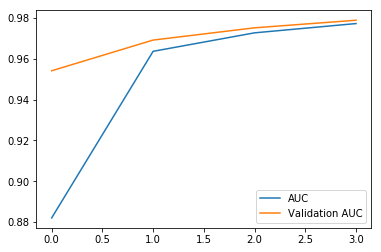

In [38]:
plt.plot(history.history['auc'], label="AUC")
plt.plot(history.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

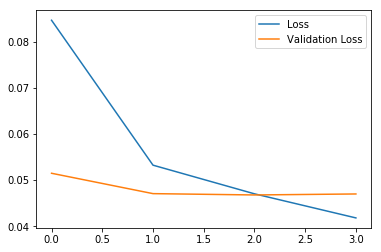

In [39]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

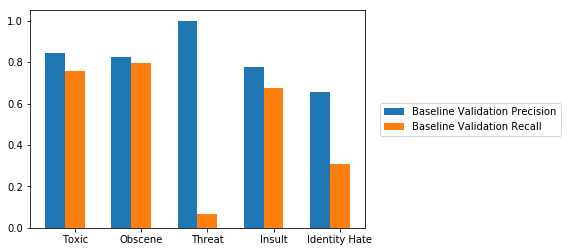

In [40]:
names = ["Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]

plt.bar(np.arange(5)-0.3/2, val_precision, 0.3, label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5)+0.3/2, val_recall, 0.3, label="Baseline Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

# Use GRU instead of LSTM

In [41]:
model2 = Sequential()
model2.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model2.add(Bidirectional(GRU(100,dropout=0.1,recurrent_dropout=0.1)))
model2.add(Dense(50, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(5, activation="sigmoid"))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240600    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total params: 6,250,905
Trainable params: 6,250,905
Non-trainable params: 0
_________________________________________________________________


In [42]:
# plot_model(model2, to_file='model2.png')

In [43]:
with tf.device('/gpu:0'):
    history2 = model2.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 128s 894us/step - loss: 0.0814 - auc: 0.8840 - val_loss: 0.0482 - val_auc: 0.9582
Epoch 2/10
143613/143613 [==============================] - 126s 874us/step - loss: 0.0504 - auc: 0.9670 - val_loss: 0.0463 - val_auc: 0.9720
Epoch 3/10
143613/143613 [==============================] - 127s 886us/step - loss: 0.0442 - auc: 0.9752 - val_loss: 0.0467 - val_auc: 0.9774


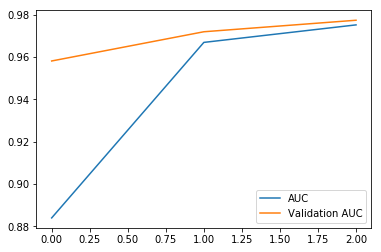

In [44]:
plt.plot(history2.history['auc'], label="AUC")
plt.plot(history2.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

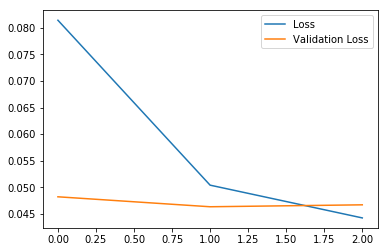

In [45]:
plt.plot(history2.history['loss'], label="Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [46]:
val_predict2 = (np.asarray(model2.predict([X_val], batch_size=512))).round()

val_precision2 = []
val_recall2 = []
for i in range(5):
    val_precision2.append(metrics.precision_score(val_target[:,i], val_predict2[:,i]))
    val_recall2.append(metrics.recall_score(val_target[:,i], val_predict2[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision2, val_recall2))

Validation Precision: [0.85159285159285159, 0.84300791556728227, 0.59999999999999998, 0.77041602465331283, 0.7142857142857143],

Validation Recall: [0.75482093663911842, 0.78694581280788178, 0.066666666666666666, 0.67114093959731547, 0.29914529914529914]


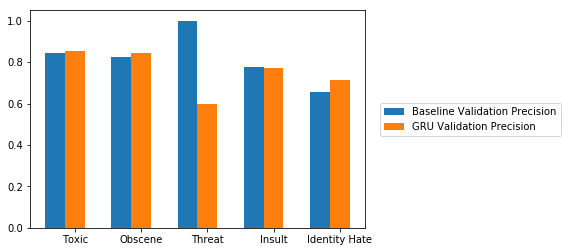

In [47]:
plt.bar(np.arange(5) - 0.3/2,val_precision,0.3,label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_precision2,0.3,label="GRU Validation Precision", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

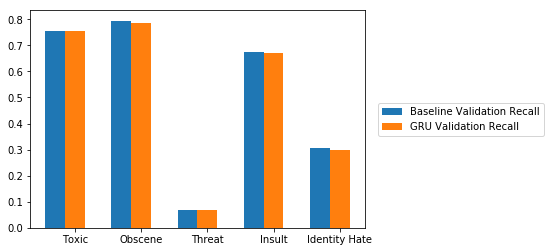

In [48]:
plt.bar(np.arange(5) - 0.3/2,val_recall,0.3,label="Baseline Validation Recall", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_recall2,0.3,label="GRU Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.55,0.5))
plt.show()

# Use Pre-trained Embedding - GoogleNews Negative 3mil

In [49]:
word2vecDict = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(
    r"C:\Users\insuf\Desktop\GoogleNews-vectors-negative300.bin", binary=True)

embed_size = 300
embeddings_index = dict()
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


Loaded 3000000 word vectors.
total embedded: 17855 common words


In [50]:
model3 = Sequential()
model3.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model3.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model3.add(Dense(50, activation="relu"))
model3.add(Dropout(0.1))
model3.add(Dense(5, activation="sigmoid"))
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 255       
Total params: 6,331,105
Trainable params: 6,331,105
Non-trainable params: 0
_________________________________________________________________


In [51]:
with tf.device('/gpu:0'):
    history3 = model3.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 162s 1ms/step - loss: 0.0937 - auc: 0.8373 - val_loss: 0.0518 - val_auc: 0.9411
Epoch 2/10
143613/143613 [==============================] - 165s 1ms/step - loss: 0.0538 - auc: 0.9558 - val_loss: 0.0479 - val_auc: 0.9638
Epoch 3/10
143613/143613 [==============================] - 158s 1ms/step - loss: 0.0467 - auc: 0.9687 - val_loss: 0.0479 - val_auc: 0.9722


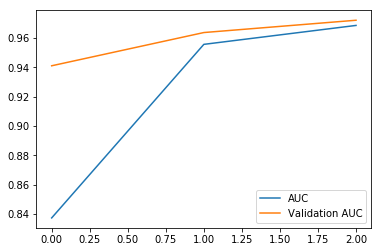

In [52]:
plt.plot(history3.history['auc'], label="AUC")
plt.plot(history3.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

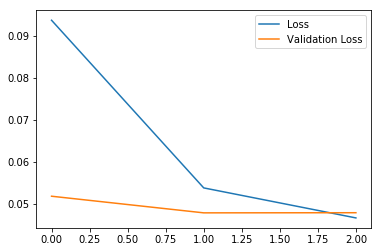

In [53]:
plt.plot(history3.history['loss'], label="Loss")
plt.plot(history3.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [54]:
val_predict3 = (np.asarray(model3.predict([X_val], batch_size=512))).round()

val_precision3 = []
val_recall3 = []
for i in range(5):
    val_precision3.append(metrics.precision_score(val_target[:,i], val_predict3[:,i]))
    val_recall3.append(metrics.recall_score(val_target[:,i], val_predict3[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision3, val_recall3))

Validation Precision: [0.81209964412811386, 0.86330935251798557, 0.0, 0.75497702909647779, 0.6875],

Validation Recall: [0.78581267217630857, 0.73891625615763545, 0.0, 0.661744966442953, 0.18803418803418803]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


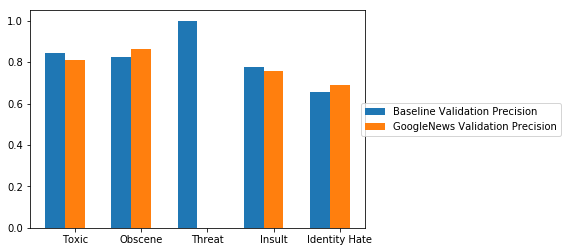

In [55]:
plt.bar(np.arange(5) - 0.3/2,val_precision,0.3,label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_precision3,0.3,label="GoogleNews Validation Precision", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

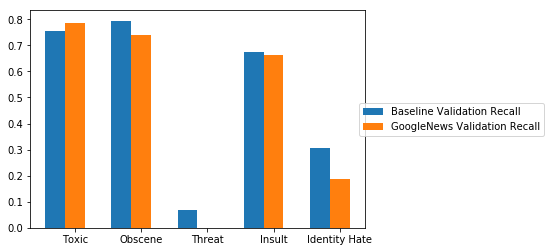

In [57]:
plt.bar(np.arange(5) - 0.3/2,val_recall,0.3,label="Baseline Validation Recall", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_recall3,0.3,label="GoogleNews Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.55,0.5))
plt.show()

# Glove Twitter 27B

In [58]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.txt", r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.w2v.txt")

In [59]:
glove = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(r"C:\Users\insuf\Desktop\glove.twitter.27B.25d.w2v.txt")

embed_size = 25
embeddings_index = dict()
for word in glove.wv.vocab:
    embeddings_index[word] = glove.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Loaded 1193515 word vectors.
total embedded: 18569 common words


In [60]:
model4 = Sequential()
model4.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model4.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model4.add(Dense(50, activation="relu"))
model4.add(Dropout(0.1))
model4.add(Dense(5, activation="sigmoid"))
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               100800    
_________________________________________________________________
dense_7 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 255       
Total params: 611,105
Trainable params: 611,105
Non-trainable params: 0
_________________________________________________________________


In [61]:
with tf.device('/gpu:0'):
    history4 = model4.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 155s 1ms/step - loss: 0.1022 - auc: 0.8204 - val_loss: 0.0560 - val_auc: 0.9273
Epoch 2/10
143613/143613 [==============================] - 149s 1ms/step - loss: 0.0609 - auc: 0.9451 - val_loss: 0.0512 - val_auc: 0.9552
Epoch 3/10
143613/143613 [==============================] - 147s 1ms/step - loss: 0.0562 - auc: 0.9605 - val_loss: 0.0507 - val_auc: 0.9641
Epoch 4/10
143613/143613 [==============================] - 150s 1ms/step - loss: 0.0533 - auc: 0.9668 - val_loss: 0.0488 - val_auc: 0.9689
Epoch 5/10
143613/143613 [==============================] - 151s 1ms/step - loss: 0.0509 - auc: 0.9707 - val_loss: 0.0476 - val_auc: 0.9722
Epoch 6/10
143613/143613 [==============================] - 150s 1ms/step - loss: 0.0486 - auc: 0.9735 - val_loss: 0.0472 - val_auc: 0.9745
Epoch 7/10
143613/143613 [==============================] - 151s 1ms/step - loss: 0.0468 - auc: 0.9755 - val_

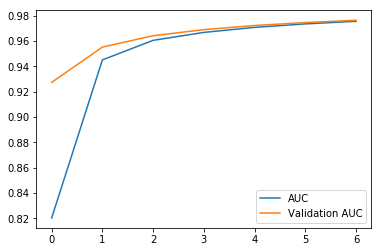

In [62]:
plt.plot(history4.history['auc'], label="AUC")
plt.plot(history4.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

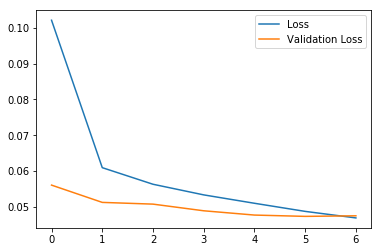

In [63]:
plt.plot(history4.history['loss'], label="Loss")
plt.plot(history4.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [64]:
val_predict4 = (np.asarray(model4.predict([X_val], batch_size=512))).round()

val_precision4 = []
val_recall4 = []
for i in range(5):
    val_precision4.append(metrics.precision_score(val_target[:,i], val_predict4[:,i]))
    val_recall4.append(metrics.recall_score(val_target[:,i], val_predict4[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision4, val_recall4))

Validation Precision: [0.85836575875486376, 0.82170542635658916, 0.0, 0.74891146589259794, 0.68000000000000005],

Validation Recall: [0.75964187327823696, 0.78325123152709364, 0.0, 0.69261744966442951, 0.14529914529914531]


C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


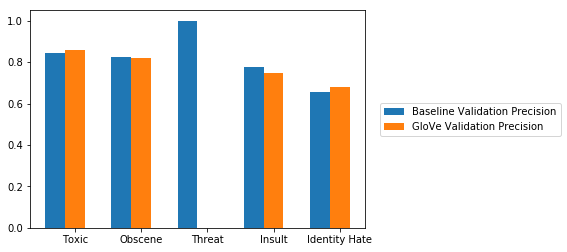

In [65]:
plt.bar(np.arange(5) - 0.3/2,val_precision,0.3,label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_precision4,0.3,label="GloVe Validation Precision", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

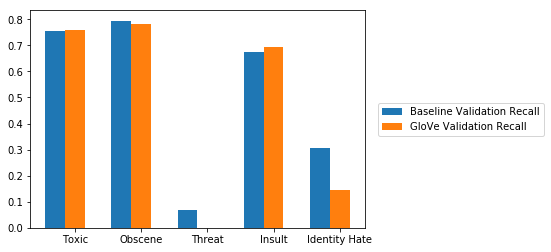

In [66]:
plt.bar(np.arange(5) - 0.3/2,val_recall,0.3,label="Baseline Validation Recall", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_recall4,0.3,label="GloVe Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.55,0.5))
plt.show()

# add more LSTM nodes

In [67]:
model9 = Sequential()
model9.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model9.add(Bidirectional(LSTM(200,dropout=0.1,recurrent_dropout=0.1)))
model9.add(Dense(100, activation="relu"))
model9.add(Dropout(0.1))
model9.add(Dense(5, activation="sigmoid"))
model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 400)               361600    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 902,205
Trainable params: 902,205
Non-trainable params: 0
_________________________________________________________________


In [68]:
with tf.device('/gpu:0'):
    history9 = model9.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_val, y_val), callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 152s 1ms/step - loss: 0.0929 - auc: 0.8498 - val_loss: 0.0550 - val_auc: 0.9403
Epoch 2/10
143613/143613 [==============================] - 147s 1ms/step - loss: 0.0592 - auc: 0.9534 - val_loss: 0.0519 - val_auc: 0.9609
Epoch 3/10
143613/143613 [==============================] - 155s 1ms/step - loss: 0.0549 - auc: 0.9652 - val_loss: 0.0500 - val_auc: 0.9681
Epoch 4/10
143613/143613 [==============================] - 162s 1ms/step - loss: 0.0517 - auc: 0.9703 - val_loss: 0.0473 - val_auc: 0.9721
Epoch 5/10
143613/143613 [==============================] - 146s 1ms/step - loss: 0.0491 - auc: 0.9736 - val_loss: 0.0469 - val_auc: 0.9749
Epoch 6/10
143613/143613 [==============================] - 146s 1ms/step - loss: 0.0469 - auc: 0.9760 - val_loss: 0.0468 - val_auc: 0.9769
Epoch 7/10
143613/143613 [==============================] - 145s 1ms/step - loss: 0.0449 - auc: 0.9778 - val_

In [69]:
val_predict9 = (np.asarray(model9.predict([X_val], batch_size=512))).round()

val_precision9 = []
val_recall9 = []
for i in range(5):
    val_precision9.append(metrics.precision_score(val_target[:,i], val_predict9[:,i]))
    val_recall9.append(metrics.recall_score(val_target[:,i], val_predict9[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision9, val_recall9))

Validation Precision: [0.85225505443234839, 0.85402455661664389, 0.0, 0.76453055141579729, 0.59154929577464788],

Validation Recall: [0.75482093663911842, 0.77093596059113301, 0.0, 0.68859060402684569, 0.35897435897435898]


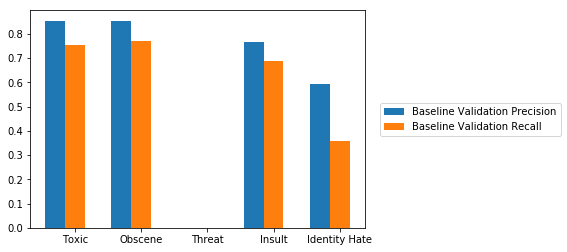

In [70]:
plt.bar(np.arange(5)-0.3/2, val_precision9, 0.3, label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5)+0.3/2, val_recall9, 0.3, label="Baseline Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

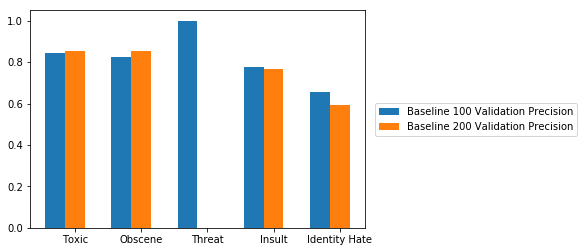

In [71]:
plt.bar(np.arange(5)-0.3/2, val_precision, 0.3, label="Baseline 100 Validation Precision", tick_label=names)
plt.bar(np.arange(5)+0.3/2, val_precision9, 0.3, label="Baseline 200 Validation Precision", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.65,0.5))
plt.show()

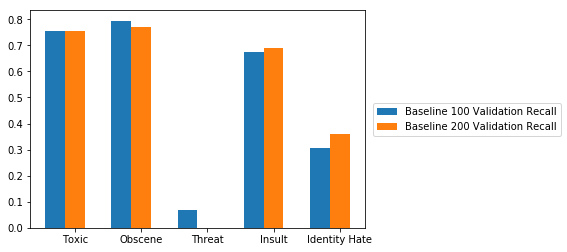

In [73]:
plt.bar(np.arange(5)-0.3/2, val_recall, 0.3, label="Baseline 100 Validation Recall", tick_label=names)
plt.bar(np.arange(5)+0.3/2, val_recall9, 0.3, label="Baseline 200 Validation Recall", tick_label=names)

plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

# Penalizing loss

In [123]:
model5 = Sequential()
model5.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model5.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model5.add(Dense(50, activation="relu"))
model5.add(Dropout(0.1))
model5.add(Dense(5, activation="sigmoid"))
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200)               100800    
_________________________________________________________________
dense_23 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 255       
Total params: 611,105
Trainable params: 611,105
Non-trainable params: 0
_________________________________________________________________


In [124]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)

In [84]:
# cw = {0:1, 1:10, 2:17, 3:300, 4:18, 5:102}

In [125]:
import math
def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

labels_dict = {0: 143346, 1: 15294, 2: 8449, 3: 478, 4: 7877, 5: 1405}
cw = create_class_weight(labels_dict)

In [127]:
with tf.device('/gpu:0'):
    history = model5.fit(X_train,y_train,
                        validation_data=(X_val, y_val),
                        batch_size=256,
                        epochs=100,
                        class_weight=cw,
                        callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/100
143613/143613 [==============================] - 176s 1ms/step - loss: 0.1085 - auc: 0.8128 - val_loss: 0.0602 - val_auc: 0.9276
Epoch 2/100
143613/143613 [==============================] - 167s 1ms/step - loss: 0.0657 - auc: 0.9452 - val_loss: 0.0516 - val_auc: 0.9554
Epoch 3/100
143613/143613 [==============================] - 161s 1ms/step - loss: 0.0610 - auc: 0.9607 - val_loss: 0.0505 - val_auc: 0.9644
Epoch 4/100
143613/143613 [==============================] - 168s 1ms/step - loss: 0.0579 - auc: 0.9671 - val_loss: 0.0487 - val_auc: 0.9692
Epoch 5/100
143613/143613 [==============================] - 168s 1ms/step - loss: 0.0554 - auc: 0.9709 - val_loss: 0.0475 - val_auc: 0.9724
Epoch 6/100
143613/143613 [==============================] - 160s 1ms/step - loss: 0.0529 - auc: 0.9736 - val_loss: 0.0471 - val_auc: 0.9748
Epoch 7/100
143613/143613 [==============================] - 163s 1ms/step - loss: 0.0509 - auc: 0.9757

In [131]:
val_predict5 = (np.asarray(model5.predict([X_val], batch_size=512))).round()

val_precision5 = []
val_recall5 = []
for i in range(5):
    val_precision5.append(metrics.precision_score(val_target[:,i], val_predict5[:,i]))
    val_recall5.append(metrics.recall_score(val_target[:,i], val_predict5[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision5, val_recall5))

Validation Precision: [0.88314987298899239, 0.80519480519480524, 0.20000000000000001, 0.72037283621837545, 0.61764705882352944],

Validation Recall: [0.7183195592286501, 0.83990147783251234, 0.022222222222222223, 0.72617449664429534, 0.35897435897435898]


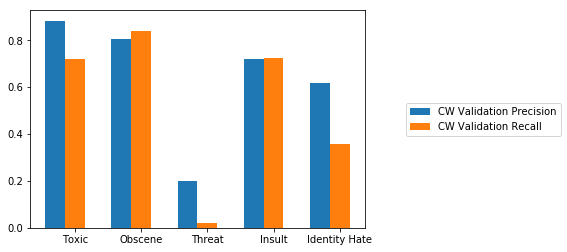

In [138]:
plt.bar(np.arange(5) - 0.3/2,val_precision5,0.3,label="CW Validation Precision", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_recall5,0.3,label="CW Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.6,0.5))
plt.show()

# Undersample

In [93]:
model6 = Sequential()
model6.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model6.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model6.add(Dense(50, activation="relu"))
model6.add(Dropout(0.1))
model6.add(Dense(5, activation="sigmoid"))
model6.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 25)           500000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               100800    
_________________________________________________________________
dense_19 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 255       
Total params: 611,105
Trainable params: 611,105
Non-trainable params: 0
_________________________________________________________________


In [94]:
y_majority_index = np.where(np.sum(y_train, axis=1)==0)[0]
y_minority_index = np.where(np.sum(y_train, axis=1)!=0)[0]
n_undersample = y_majority_index.shape[0]*0.1

rauc = []
rval_auc = []
rloss = []
rval_loss = []

while True:
    index_undersample = np.random.choice(y_majority_index,int(n_undersample),replace=False)
    new_index_undersample = np.concatenate([y_minority_index, index_undersample])
    x_train_new = X_train[new_index_undersample,:]
    y_train_new = y_train[new_index_undersample,:]
    with tf.device('/gpu:0'):
        hist = model6.fit(x_train_new,y_train_new,validation_data=(X_val, y_val),batch_size=256,epochs=1)
    rauc.append(hist.history["auc"])
    rval_auc.append(hist.history["val_auc"])
    rloss.append(hist.history["loss"])
    rval_loss.append(hist.history["val_loss"])
    if rval_loss[-1] > rloss[-1]:
        break

Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 34s 1ms/step - loss: 0.3800 - auc: 0.7741 - val_loss: 0.1359 - val_auc: 0.8691
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 36s 1ms/step - loss: 0.2784 - auc: 0.8937 - val_loss: 0.0811 - val_auc: 0.9092
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 39s 1ms/step - loss: 0.2432 - auc: 0.9196 - val_loss: 0.0891 - val_auc: 0.9266
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 38s 1ms/step - loss: 0.2262 - auc: 0.9318 - val_loss: 0.0760 - val_auc: 0.9362
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 33s 1ms/step - loss: 0.2151 - auc: 0.9398 - val_loss: 0.0731 - val_auc: 0.9427
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/2759

27593/27593 [==============================] - 30s 1ms/step - loss: 0.0941 - auc: 0.9807 - val_loss: 0.0761 - val_auc: 0.9808
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 31s 1ms/step - loss: 0.0909 - auc: 0.9809 - val_loss: 0.0749 - val_auc: 0.9810
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 30s 1ms/step - loss: 0.0887 - auc: 0.9812 - val_loss: 0.0768 - val_auc: 0.9813
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 30s 1ms/step - loss: 0.0879 - auc: 0.9814 - val_loss: 0.0800 - val_auc: 0.9815
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 30s 1ms/step - loss: 0.0854 - auc: 0.9816 - val_loss: 0.0788 - val_auc: 0.9817
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 31s 1ms/step - loss: 0.

In [96]:
val_predict6 = (np.asarray(model6.predict([X_val], batch_size=512))).round()

val_precision6 = []
val_recall6 = []
for i in range(5):
    val_precision6.append(metrics.precision_score(val_target[:,i], val_predict6[:,i]))
    val_recall6.append(metrics.recall_score(val_target[:,i], val_predict6[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision6, val_recall6))

Validation Precision: [0.60338345864661658, 0.74263038548752835, 0.31428571428571428, 0.642018779342723, 0.34838709677419355],

Validation Recall: [0.88429752066115708, 0.80665024630541871, 0.24444444444444444, 0.73422818791946309, 0.46153846153846156]


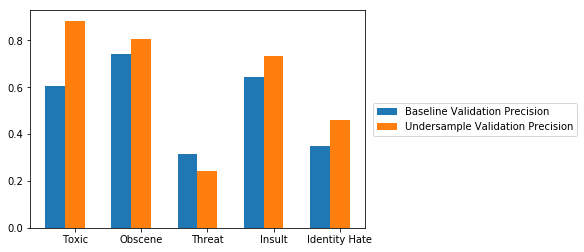

In [139]:
plt.bar(np.arange(5) - 0.3/2,val_precision6,0.3,label="Baseline Validation Precision", tick_label=names)
plt.bar(np.arange(5) + 0.3/2,val_recall6,0.3,label="Undersample Validation Precision", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.65,0.5))
plt.show()